try using the EPA's average PM 2.5 concentration for each census tract instead of my DIY method
does it look different? does it correlate with asthma?

THIS WORKS WAY BETTER WHY DOES IT WORK WAY BETTER

what does the EPA know about air quality that I don't (a lot)

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from pykrige.ok import OrdinaryKriging

from air_brain.data.get_data import DATA_DIR
from air_brain.util.air import PM25
from air_brain.util.od import od

tract_file = os.path.join(DATA_DIR, "tl_2010_42003_tract10", "tl_2010_42003_tract10.shp")
county_file = os.path.join(DATA_DIR, "county.geojson")
sensor_file = os.path.join(DATA_DIR, "sensor_json.geojson")

In [2]:
tracts = gpd.read_file(tract_file)
tracts.GEOID10 = tracts.GEOID10.astype(int)

In [3]:
asthma_file = os.path.join(DATA_DIR, "asthma.csv")
asthma = pd.read_csv(asthma_file)
# convert all numerators to fractions
for col in ["ED_visits", "ED_hosp", "UC_visits", "Asthma_use"]:
    asthma["{}_frac".format(col)] = asthma[col] / asthma.Total_members

In [4]:
epa_file = os.path.join(DATA_DIR, "EJSCREEN_2017_USPR_Public.csv")
pm25 = pd.read_csv(epa_file)[["ID", "PM25", "AREALAND", "AREAWATER"]]
# STATE (2 - digits) + COUNTY (3) + TRACT (6) + BLOCK GROUP (1) + BLOCK (3)
# just Allegheny County census block groups
pm25 = pm25.loc[pm25.ID.astype(str).str.startswith("42003")]
# just the tract, not the block
pm25.ID = pm25.ID.astype(str).str[:-1].astype(int)
# because of how PM 2.5 works, appropriate to average over tract
# weight by block area
pm25['area'] = pm25.AREALAND + pm25.AREAWATER
pm25['pm25xarea'] = pm25.PM25*pm25.area
pm25 = pm25.groupby("ID").agg({'pm25xarea': 'sum',
                               'area': 'sum'}).reset_index()
pm25['pm25_avg'] = pm25.pm25xarea / pm25.area

In [5]:
df = asthma.merge(pm25, left_on="Census_tract", right_on="ID", how="left", validate="1:1")
df.head()

,Census_tract,ED_visits,ED_hosp,UC_visits,Asthma_use,Total_members,ED_visits_frac,ED_hosp_frac,UC_visits_frac,Asthma_use_frac,ID,pm25xarea,area,pm25_avg
0,42003010300,2,0,0,6,83,0.024096,0.000000,0.000000,0.072289,42003010300,1.167933e+07,1102069.0,10.597638
1,42003020100,32,19,3,223,2114,0.015137,0.008988,0.001419,0.105487,42003020100,2.286661e+07,2161279.0,10.580130
2,42003020300,0,0,0,2,48,0.000000,0.000000,0.000000,0.041667,42003020300,2.035721e+07,1921327.0,10.595392
3,42003030500,11,3,3,61,422,0.026066,0.007109,0.007109,0.144550,42003030500,7.078291e+06,667737.0,10.600417
4,42003040200,2,1,1,18,138,0.014493,0.007246,0.007246,0.130435,42003040200,6.509786e+06,613247.0,10.615276


['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'Census_tract', 'ED_visits', 'ED_hosp', 'UC_visits', 'Asthma_use', 'Total_members', 'ED_visits_frac', 'ED_hosp_frac', 'UC_visits_frac', 'Asthma_use_frac', 'ID', 'pm25xarea', 'area', 'pm25_avg']


<Axes: >

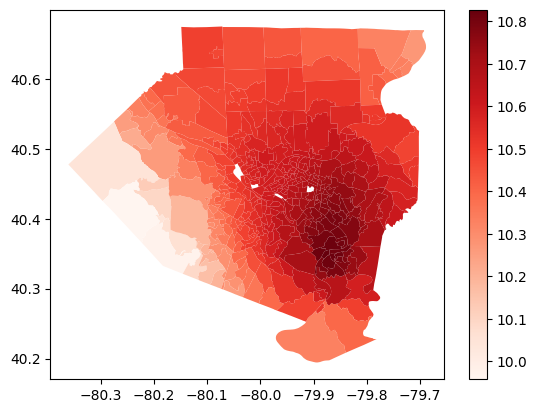

In [6]:
geom_df = tracts.merge(df, left_on="GEOID10", right_on="ID", how="right", validate="1:1")
geom_df.plot(column="pm25_avg", cmap="Reds", legend=True)

<Axes: xlabel='pm25_avg', ylabel='ED_hosp_frac'>

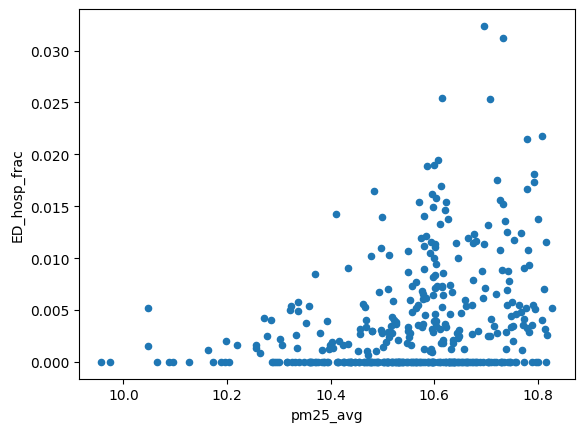

In [9]:
df.plot(x="pm25_avg", y="ED_hosp_frac", kind="scatter")